# Step 1: Extract data

In [6]:
# Download data from yfinance

import os
from datetime import datetime, timedelta

import yfinance as yf

start_date = datetime(2015, 1, 1)
end_date = datetime.today() - timedelta(days=1)

output_folder = 'ds'
os.makedirs(output_folder, exist_ok=True)

tickers = {
    'BTC-USD': 'btc_usd_yfinance.csv',
    'AAPL': 'aapl_yfinance.csv'
}

for ticker, filename in tickers.items():
    print(f'Downloading data for {ticker}...')
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df.columns = df.columns.droplevel(1)
    output_path = os.path.join(output_folder, filename)
    df.to_csv(output_path, index=False)
    print(f'Saved: {output_path}')

/var/folders/ht/70hjrhkx4j305ctfw65z_43h0000gn/T/ipykernel_45823/3176228711.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/ht/70hjrhkx4j305ctfw65z_43h0000gn/T/ipykernel_45823/3176228711.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)


Saved: ds/btc_usd_yfinance.csv


[*********************100%***********************]  1 of 1 completed

Saved: ds/aapl_yfinance.csv


In [12]:
# Download data from alpha vantage

import os
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.timeseries import TimeSeries

API_KEY = 'M7LSRK3RRO78M3ZE'
output_folder = 'ds'
os.makedirs(output_folder, exist_ok=True)

start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download BTC-USD (crypto)
print('Downloading BTC-USD...')
crypto_api = CryptoCurrencies(key=API_KEY, output_format='pandas')
btc_data, _ = crypto_api.get_digital_currency_daily(symbol='BTC', market='USD')
btc_data = btc_data.rename_axis('Date').reset_index()
btc_data = btc_data[['Date', '1. open', '2. high', '3. low', '4. close', '5. volume']]
btc_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
btc_data = btc_data.sort_values('Date')
btc_data = btc_data[(btc_data['Date'] >= start_date) & (btc_data['Date'] <= end_date)]
btc_data.to_csv(os.path.join(output_folder, 'btc_usd_alphavantage.csv'), index=False)
print('Saved: btc_usd_alphavantage.csv')
#
# # Download AAPL (stock)
print('Downloading AAPL...')
stock_api = TimeSeries(key=API_KEY, output_format='pandas')
aapl_data, _ = stock_api.get_daily(symbol='AAPL', outputsize='full')
aapl_data = aapl_data.rename_axis('Date').reset_index()
aapl_data = aapl_data[['Date', '1. open', '2. high', '3. low', '4. close', '5. volume']]
aapl_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
aapl_data = aapl_data.sort_values('Date')
aapl_data = aapl_data[(aapl_data['Date'] >= start_date) & (aapl_data['Date'] <= end_date)]
aapl_data.to_csv(os.path.join(output_folder, 'aapl_alphavantage.csv'), index=False)
print('Saved: aapl_alphavantage.csv')

Saved: btc_usd_alphavantage.csv
Saved: aapl_alphavantage.csv


# Step 2: preprocess data

In [59]:
# Select desired dataset

import pandas as pd

file_name = 'ds/btc_usd_yfinance.csv'
df = pd.read_csv(file_name)
df['Date'] = pd.to_datetime(df['Date'])

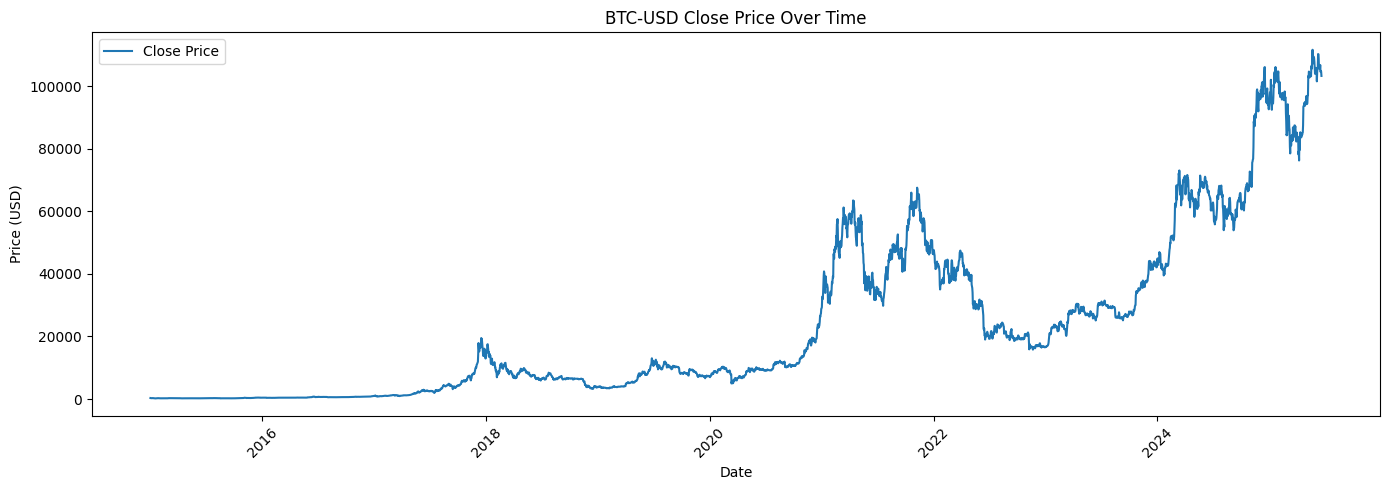

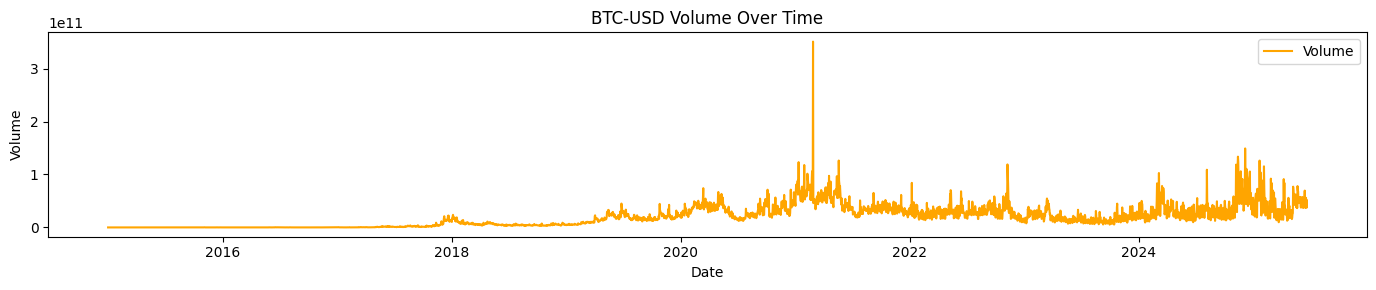

In [60]:
# Exploratory Data Analysis

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.xticks(rotation=45)
plt.title('BTC-USD Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Volume
plt.figure(figsize=(14, 3))
plt.plot(df['Date'], df['Volume'], color='orange', label='Volume')
plt.title('BTC-USD Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()

## Technical analysis indicators:
- **SMA (Simple Moving Average)**: Averages past closing prices to smooth out trends.
- **EMA (Exponential Moving Average)**: Like SMA but gives more weight to recent prices.
- **RSI (Relative Strength Index)**: Measures momentum to identify overbought or oversold conditions.
- **MACD (Moving Average Convergence Divergence)**: Tracks trend strength and momentum using moving averages.

In [35]:
# Calculate finance technical analysis indicators

from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator

WINDOW = 14

df['SMA'] = SMAIndicator(close=df['Close'], window=WINDOW).sma_indicator()
df['EMA'] = EMAIndicator(close=df['Close'], window=WINDOW).ema_indicator()
df['RSI'] = RSIIndicator(close=df['Close'], window=WINDOW).rsi()

macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

df = df.dropna()
df.to_csv('ds/dataset_ta.csv', index=False)

In [50]:
# Normalize and fill gaps

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load the dataset
df = pd.read_csv('ds/dataset_ta.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.drop(columns=['High', 'Low', 'Open'])

# Reindex to ensure all calendar days are present (including holidays)
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates)

# Forward fill missing values for all relevant columns
columns_to_fill = ['Close', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff']
df[columns_to_fill] = df[columns_to_fill].ffill()

# Normalize all features using MinMaxScaler
df[columns_to_fill] = MinMaxScaler(feature_range=(0, 1)).fit_transform(df[columns_to_fill])

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_close.fit(df[['Close']])

# Reset index and save to CSV
df = df.reset_index().rename(columns={'index': 'Date'})
df.to_csv('ds/dataset_ta_processed.csv', index=False)

features = df[columns_to_fill].values


In [51]:
import numpy as np

# Prepare data with a window (loop back)
window_size = 120
X_data, y_data = [], []

# Rolling windows: every window_size consecutive values are used as input to predict the 121st value (next day forecast)
# Another option: TimeSeriesSplit
for i in range(window_size, len(features)):
    X_data.append(features[i-window_size:i, :])
    y_data.append(features[i, 0])

X_data, y_data = np.array(X_data), np.array(y_data)
X_data = np.reshape(X_data, shape=(X_data.shape[0], X_data.shape[1], features.shape[1]))

# Step 3: training

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dropout, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

technique = LSTM  # SimpleRNN, GRU, LSTM

split_ratio = 0.8
train_size = int(len(X_data) * split_ratio)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

batch_size = 32
timesteps = X_train.shape[1]
features_dim = X_train.shape[2]

def trim_to_batch_size(X, y, batch_size):
    size = (len(X) // batch_size) * batch_size
    return X[:size], y[:size]

X_train_s, y_train_s = trim_to_batch_size(X_train, y_train, batch_size)
X_test_s, y_test_s = trim_to_batch_size(X_test, y_test, batch_size)

model = Sequential()
model.add(InputLayer(batch_input_shape=(batch_size, timesteps, features_dim)))
model.add(technique(units=32, return_sequences=True, stateful=True))
model.add(Dropout(0.3))
model.add(technique(units=16, return_sequences=False, stateful=True))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=True)

history = model.fit(
    X_train_s, y_train_s,
    epochs=30,
    batch_size=batch_size,
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0075 - learning_rate: 0.0010
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 12

# Step 4: Evaluate model

In [63]:
# Evaluate model quality
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

test_loss = model.evaluate(X_test_s, y_test_s, batch_size=batch_size)
print(f'Test loss: {test_loss:.4f}')

# Make predictions on the test set
print('Making predictions...')
predictions = model.predict(X_test_s)

# 4. Invert the normalization to get original values
predictions = scaler_close.inverse_transform(predictions)
y_test_inv = scaler_close.inverse_transform(y_test_s.reshape(-1, 1))

# 5. Model evaluation
mse = mean_squared_error(y_test_inv, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, predictions)
mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')  # How many dollars in average the model has errors
print(f'MAE: {mae}')  #
print(f'MAPE: {mape}%')  # % of error

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057
Test loss: 0.0151
Making predictions...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE: 0.01505010905888174
RMSE: 0.12267888595386632
MAE: 0.10375924319501059
MAPE: 17.120496978341173%


# Step 5: Use model

In [64]:
import numpy as np
import matplotlib.pyplot as plt

days = 14
n_features = features.shape[1]
batch_size = 32
window_size = 120

last_sequence = features[-window_size:].copy()  # shape: (120, 8)
sequence = last_sequence.reshape(1, window_size, n_features)  # shape: (1, 120, 8)

next_predictions = []

for _ in range(days):
    sequence_batch = np.repeat(sequence, repeats=batch_size, axis=0)  # shape: (32, 120, 8)

    next_close_norm = model.predict(sequence_batch, batch_size=batch_size, verbose=0)[0][0]
    next_predictions.append(next_close_norm)

    last_row = sequence[0, -1, :].copy()
    last_row[0] = next_close_norm  # atualiza somente o 'Close'

    new_row = last_row.reshape(1, 1, n_features)
    sequence = np.append(sequence[:, 1:, :], new_row, axis=1)

next_predictions_real = scaler_close.inverse_transform(np.array(next_predictions).reshape(-1, 1))

print(f'Next {days} closing price forecasts:')
print(next_predictions_real.flatten())

Next 14 closing price forecasts:
[0.7058174  0.69461304 0.6820734  0.66977346 0.65867347 0.6491616
 0.6413216  0.63507205 0.63025    0.62666017 0.6241036  0.62239236
 0.62135696 0.62085   ]


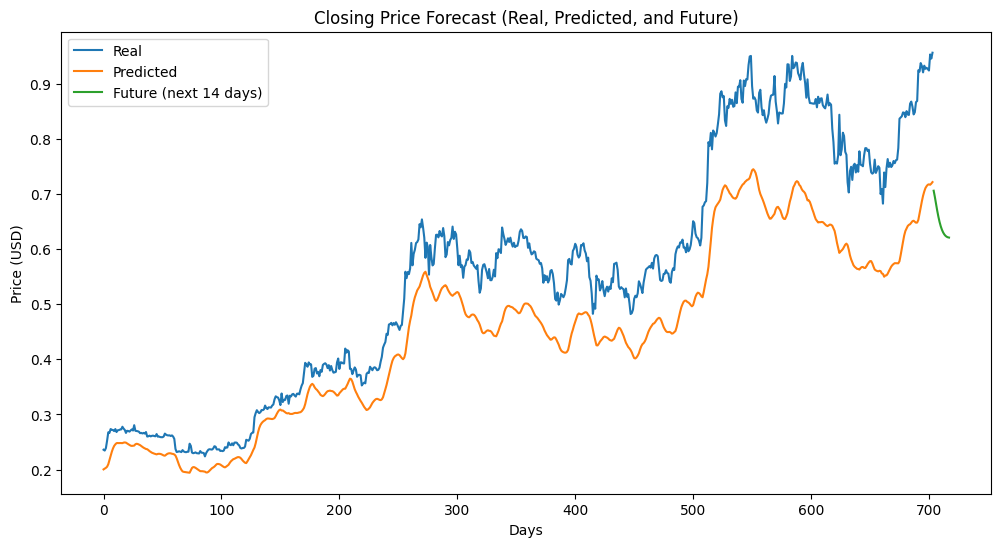

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_inv)), y_test_inv, label='Real')
plt.plot(np.arange(len(predictions)), predictions, label='Predicted')
plt.plot(np.arange(len(y_test_inv), len(y_test_inv) + days), next_predictions_real, label=f'Future (next {days} days)')

plt.title('Closing Price Forecast (Real, Predicted, and Future)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

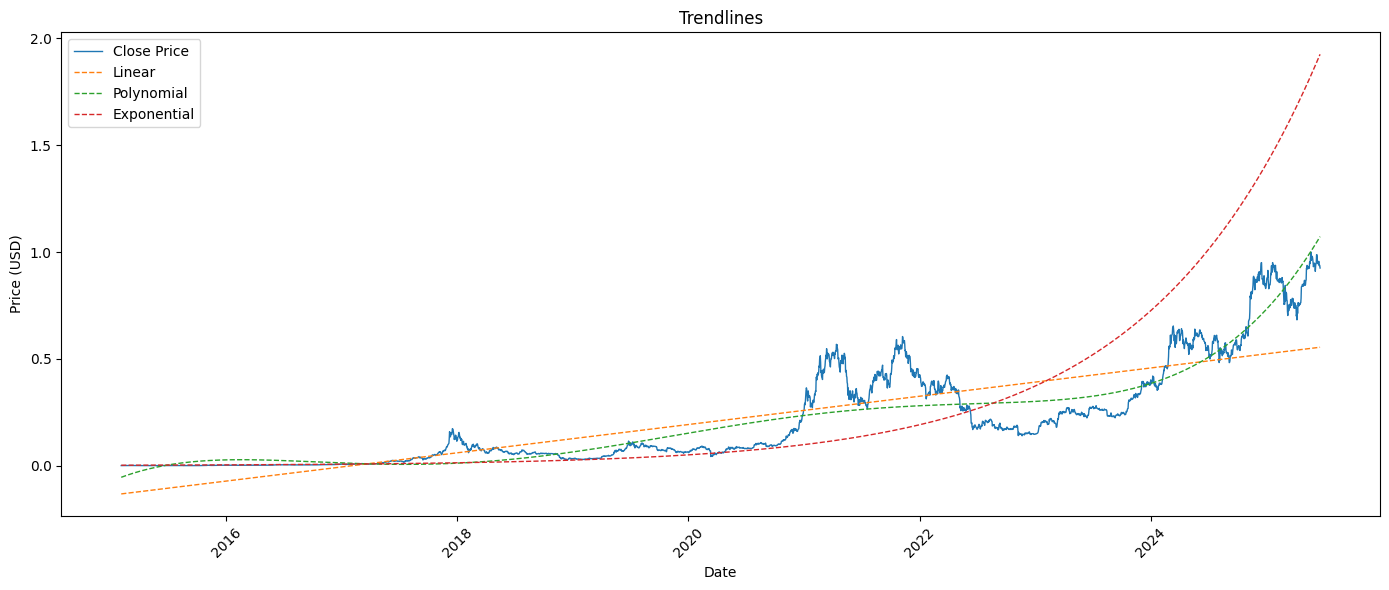

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = df.dropna(subset=['Close']).copy()
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)

x = df['Date_ordinal']
y = df['Close']

# Linear fit (ok com x grande)
linear_coef = np.polyfit(x, y, 1)
linear_fit = np.poly1d(linear_coef)

# Polynomial fit (grau alto = centraliza x)
x_centered = x - x.mean()
poly_coef = np.polyfit(x_centered, y, 5)
poly_fit = np.poly1d(poly_coef)

# Exponential fit (usa log, precisa y > 0 e x centralizado)
mask = y > 0
x_exp = x[mask]
y_exp = y[mask]
x_exp_centered = x_exp - x_exp.mean()
exp_coef = np.polyfit(x_exp_centered, np.log(y_exp), 1)
exp_fit = lambda t: np.exp(exp_coef[1]) * np.exp(exp_coef[0] * (t - x_exp.mean()))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], y, label='Close Price', linewidth=1)
plt.plot(df['Date'], linear_fit(x), '--', label='Linear', linewidth=1)
plt.plot(df['Date'], poly_fit(x - x.mean()), '--', label='Polynomial', linewidth=1)
plt.plot(df['Date'], exp_fit(x), '--', label='Exponential', linewidth=1)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Trendlines')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

y_true = y.values
y_linear = linear_fit(x)
y_poly = poly_fit(x - x.mean())
y_exp = exp_fit(x)

# Linear
mse_linear = mean_squared_error(y_true, y_linear)
rmse_linear = rmse(y_true, y_linear)
mae_linear = mean_absolute_error(y_true, y_linear)
mape_linear = mape(y_true, y_linear)

# Polynomial
mse_poly = mean_squared_error(y_true, y_poly)
rmse_poly = rmse(y_true, y_poly)
mae_poly = mean_absolute_error(y_true, y_poly)
mape_poly = mape(y_true, y_poly)

# Exponential
mse_exp = mean_squared_error(y_true, y_exp)
rmse_exp = rmse(y_true, y_exp)
mae_exp = mean_absolute_error(y_true, y_exp)
mape_exp = mape(y_true, y_exp)

print('Linear Trendline:')
print(f'  MSE:  {mse_linear:.4f}')
print(f'  RMSE: {rmse_linear:.4f}')
print(f'  MAE:  {mae_linear:.4f}')
print(f'  MAPE: {mape_linear:.2f}%')

print('\nPolynomial Trendline:')
print(f'  MSE:  {mse_poly:.4f}')
print(f'  RMSE: {rmse_poly:.4f}')
print(f'  MAE:  {mae_poly:.4f}')
print(f'  MAPE: {mape_poly:.2f}%')

print('\nExponential Trendline:')
print(f'  MSE:  {mse_exp:.4f}')
print(f'  RMSE: {rmse_exp:.4f}')
print(f'  MAE:  {mae_exp:.4f}')
print(f'  MAPE: {mape_exp:.2f}%')

Linear Trendline:
  MSE:  0.0185
  RMSE: 0.1360
  MAE:  0.1064
  MAPE: 3895.83%

Polynomial Trendline:
  MSE:  0.0083
  RMSE: 0.0913
  MAE:  0.0688
  MAPE: 779.62%

Exponential Trendline:
  MSE:  0.0688
  RMSE: 0.2624
  MAE:  0.1571
  MAPE: 134.56%
